In [30]:
import pandas as pd
import requests
import json
import numpy as np
from math import exp

from graph_traffic.config import data_path
from graph_traffic.custom_transformer import transform_df

path = f"{data_path}/04-traffic-meteo-merged"
ubs_path = f"{data_path}/01-raw/traffic/ubs.csv"
dataset_id = 1

# transformations in columns
rain = "ordinal"
wind = "wind_speed"
season = "ordinal"
month = "spline"
day_of_month = "trigonometric"
hour = "spline"
interactions = None

Select which ids we want to have in our model

In [31]:
ids = [3954, 3973, 3976, 3977, 3978]

# 1. Define the structure of the graph

In [32]:
ubs = pd.read_csv(ubs_path)
ubs = ubs[ubs["id"].isin(ids)].set_index("id")
ubs

,longitud,latitud
id,,
3954,-3.678813,40.440254
3973,-3.678922,40.440663
3976,-3.680269,40.440019
3977,-3.679625,40.439718
3978,-3.679097,40.441216


Compute the weights of the edges between nodes between nodes

In [33]:
distances = pd.DataFrame(index=ubs.index.rename("origin"), columns=ubs.index.rename("target"))
for origin in ubs.index.values:
    olong = ubs.loc[origin, "longitud"]
    olat = ubs.loc[origin, "latitud"]
    d = []
    for target in ubs.index.values:
        if origin == target:
            continue
        tlong = ubs.loc[target, "longitud"]
        tlat = ubs.loc[target, "latitud"]
        request_path = f"http://router.project-osrm.org/route/v1/car/{olong},{olat};{tlong},{tlat}?overview=false"
        r = requests.get(request_path)# then you load the response using the json libray
        # by default you get only one alternative so you access 0-th element of the `routes`
        routes = json.loads(r.content)
        route_1 = routes.get("routes")[0]
        distances.loc[origin, target] = route_1["duration"]
distances = distances.astype(float)

# manual manipulation of distances
distances.loc[3978, 3973] = 60
distances.loc[3973, 3978] = 90
distances.loc[3976, 3978] = 150
distances.loc[3977, 3978] = 60


std = np.nanstd(distances.to_numpy().ravel())
def get_weight(distance):
    return exp(-distance**2 / std**2)

weights = distances.applymap(get_weight).fillna(0).round(4)#.rename(index=ubs_dict, columns=ubs_dict)
weights

target,3954,3973,3976,3977,3978
origin,,,,,
3954,0.0000,0.2523,0.0192,0.0155,0.3520
3973,0.0000,0.0000,0.0200,0.4712,0.0056
3976,0.0016,0.0000,0.0000,0.0000,0.0000
3977,0.0019,0.2180,0.2915,0.0000,0.1000
3978,0.0416,0.1000,0.3932,0.1465,0.0000


In [34]:
distances

target,3954,3973,3976,3977,3978
origin,,,,,
3954,NaN,46.4,78.6,80.7,40.4
3973,133.1,NaN,78.2,34.3,90.0
3976,100.1,139.6,NaN,173.9,150.0
3977,98.8,48.8,43.9,NaN,60.0
3978,70.5,60.0,38.2,54.8,NaN


The ids in the graph need to start from 0 -> We reindex the ids

In [35]:
ubs_dict = ubs.reset_index()[["id"]].reset_index().set_index("id").to_dict()["index"]
ubs_dict

{3954: 0, 3973: 1, 3976: 2, 3977: 3, 3978: 4}

In [36]:
ubs["id_graph"] = ubs.index.map(lambda x: ubs_dict[x])
ubs

,longitud,latitud,id_graph
id,,,
3954,-3.678813,40.440254,0
3973,-3.678922,40.440663,1
3976,-3.680269,40.440019,2
3977,-3.679625,40.439718,3
3978,-3.679097,40.441216,4


Distribution of the weights

In [37]:
pd.Series(weights.values.ravel()).quantile([0.1*x for x in range(11)])

0.0    0.00000
0.1    0.00000
0.2    0.00000
0.3    0.00000
0.4    0.00178
0.5    0.01550
0.6    0.02864
0.7    0.10000
0.8    0.22486
0.9    0.32780
1.0    0.47120
dtype: float64

Define a threshold for the weights of the edges.
List of source/target nodes

In [38]:
weights_lim = weights[weights>0.01].stack()
nodes_src, nodes_target = zip(*weights_lim.index)
nodes_src = np.array(nodes_src)
nodes_target = np.array(nodes_target)
weights_lim

origin  target
3954    3973      0.2523
        3976      0.0192
        3977      0.0155
        3978      0.3520
3973    3976      0.0200
        3977      0.4712
3977    3973      0.2180
        3976      0.2915
        3978      0.1000
3978    3954      0.0416
        3973      0.1000
        3976      0.3932
        3977      0.1465
dtype: float64

Reindex the lists of source/target nodes

In [39]:
nodes_src_graph = np.array([ubs_dict[x] for x in nodes_src])
nodes_target_graph = np.array([ubs_dict[x] for x in nodes_target])

# 2. Create the DGLDataset

In [40]:
import dgl
from dgl.data import DGLDataset
import torch
import os

class MadridTrafficDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='madrid_traffic')

    def process(self):
        #nodes_data = ubs
        #node_features = torch.from_numpy(nodes_data['longitud'].to_numpy())
        #edge_features = weights.values
        edges_src = torch.from_numpy(nodes_src_graph)
        edges_dst = torch.from_numpy(nodes_target_graph)

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=ubs.shape[0])
        #self.graph.ndata['feat'] = node_features
        self.graph.edata['weight'] = torch.from_numpy(weights_lim.values)

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = ubs.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = MadridTrafficDataset()
graph = dataset[0]

print(graph)

Graph(num_nodes=5, num_edges=13,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


In [41]:
ubs_dict
labels_dict = {v: k for (k, v) in ubs_dict.items()}
labels_dict

{0: 3954, 1: 3973, 2: 3976, 3: 3977, 4: 3978}

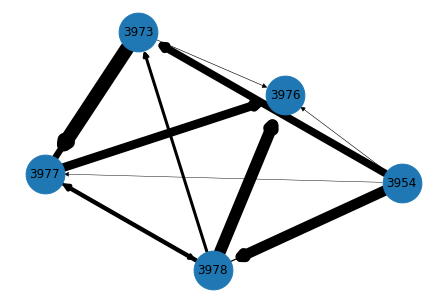

In [42]:
import networkx as nx
nx_G = graph.to_networkx()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, labels=labels_dict, width=graph.edata["weight"].numpy()*30, node_size=1500)
#labels = nx.get_edge_attributes(nx_G,'weight')
#nx.draw_networkx_edge_labels(nx_G,pos,edge_labels=labels)

Save the graph

In [43]:
dgl.save_graphs(f"{data_path}/05-graph-data/{dataset_id:03d}-dataset/graph.bin", [graph])

# 3. Create the array data

In [44]:
data = {}

for i in ids:
    df = pd.read_csv(f"{path}/{i}.csv", parse_dates=["fecha"])
    data[i] = transform_df(df, rain, wind, season, month, day_of_month, hour, interactions)
n_rows = data[i].shape[0]
n_features = data[i].shape[1]
seq_len = 12

In [45]:
arrx = np.full((n_rows, seq_len, len(ids), n_features), np.nan)
for sensor, df in data.items():
    graph_id = ubs_dict[sensor]
    dfi = pd.DataFrame(df)
    for period in range(seq_len):
        arrx[:, period, graph_id, :] = dfi.shift(-period).values
arrx.shape

(70081, 12, 5, 37)

In [46]:
arrx[:, 0, 0, :]

array([[67.,  0.,  0., ...,  1.,  0.,  1.],
       [25.,  0.,  0., ...,  1.,  0.,  1.],
       [85.,  0.,  0., ...,  1.,  0.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]])

In [47]:
arrx[:, 1, 0, :]

array([[ 25.,   0.,   0., ...,   1.,   0.,   1.],
       [ 85.,   0.,   0., ...,   1.,   0.,   1.],
       [172.,   0.,   0., ...,   1.,   0.,   1.],
       ...,
       [  0.,   0.,   0., ...,   0.,   1.,   1.],
       [  0.,   0.,   0., ...,   0.,   1.,   1.],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [48]:
arrx = arrx[:-seq_len]
arrx.shape

(70069, 12, 5, 37)

In [49]:
arry = arrx[seq_len:, :, :, :]
arry.shape

(70057, 12, 5, 37)

In [50]:
arrx = arrx[:-seq_len]
arrx.shape

(70057, 12, 5, 37)

In [51]:
data_size = len(arrx)
data_size

70057

In [52]:
0.6*data_size / 64

656.784375

In [53]:
np.savez(f"{data_path}/05-graph-data/{dataset_id:03d}-dataset/{dataset_id:03d}_dataset.npz", x=arrx, y=arry)
np.savez(f"{data_path}/05-graph-data/{dataset_id:03d}-dataset/{dataset_id:03d}_train.npz", x=arrx[:int(0.6 * data_size)], y=arry[:int(0.6 * data_size)])
np.savez(f"{data_path}/05-graph-data/{dataset_id:03d}-dataset/{dataset_id:03d}_valid.npz", x=arrx[int(0.6 * data_size):int(0.8 * data_size)], y=arry[int(0.6 * data_size):int(0.8 * data_size)])
np.savez(f"{data_path}/05-graph-data/{dataset_id:03d}-dataset/{dataset_id:03d}_test.npz", x=arrx[int(0.8 * data_size):], y=arry[int(0.8 * data_size):])

In [54]:
np.count_nonzero(np.isnan(arrx))

0

In [55]:
np.count_nonzero(np.isnan(arry))

0

In [56]:
arrx.size

155526540

In [57]:
arrx

array([[[[6.70000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [2.00000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [4.00000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [7.50000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [8.30000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00]],

        [[2.50000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
         [5.30000000e+

In [58]:
data

{3954: array([[67.,  0.,  0., ...,  1.,  0.,  1.],
        [25.,  0.,  0., ...,  1.,  0.,  1.],
        [85.,  0.,  0., ...,  1.,  0.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.]]),
 3973: array([[ 20.   ,   0.   ,   0.   , ...,   1.   ,   0.   ,   1.   ],
        [  0.   ,   0.   ,   0.   , ...,   1.   ,   0.   ,   1.   ],
        [ 27.   ,   0.   ,   0.   , ...,   1.   ,   0.   ,   1.   ],
        ...,
        [218.   ,   5.15 ,  64.   , ...,   0.   ,   1.   ,   1.   ],
        [244.   ,   5.025,  64.5  , ...,   0.   ,   1.   ,   1.   ],
        [220.   ,   4.9  ,  65.   , ...,   0.   ,   1.   ,   1.   ]]),
 3976: array([[ 40.   ,   0.   ,   0.   , ...,   1.   ,   0.   ,   1.   ],
        [  0.   ,   0.   ,   0.   , ...,   1.   ,   0.   ,   1.   ],
        [ 60.   ,   0.   ,   0.   , ...,   1.   ,   0.   ,   1.   ],
        ...,
        [321.   ,   5.15 ,  64.   , ...,   0.   